In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score, explained_variance_score, mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing the data and creating the data frame

url = 'https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv'
census_df = pd.read_csv(url, sep=',')
census_df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [3]:
# Statstical Analysis of the data frame

census_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,32560.0,38.581634,13.640642,17.0,28.0,37.0,48.0,90.0
Fnlwgt,32560.0,189781.814373,105549.764924,12285.0,117831.5,178363.0,237054.5,1484705.0
Education_num,32560.0,10.080590,2.572709,1.0,9.0,10.0,12.0,16.0
Capital_gain,32560.0,1077.615172,7385.402999,0.0,0.0,0.0,0.0,99999.0
Capital_loss,32560.0,87.306511,402.966116,0.0,0.0,0.0,0.0,4356.0
Hours_per_week,32560.0,40.437469,12.347618,1.0,40.0,40.0,45.0,99.0


In [4]:
# Shape of the data frame

census_df.shape

(32560, 15)

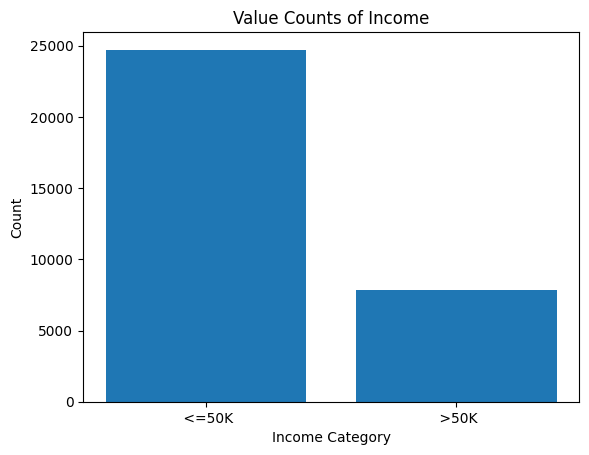

In [6]:
# Count the occurrences of each unique value in the 'Income' column

value_counts = census_df['Income'].value_counts()
value_counts = value_counts.reset_index()
value_counts.columns = ['Income Category', 'Count']
plt.bar(value_counts['Income Category'], value_counts['Count'])
plt.xlabel('Income Category')
plt.ylabel('Count')
plt.title('Value Counts of Income')
plt.show()

In [7]:
# Datatypes of the columns

census_df.dtypes

Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education_num      int64
Marital_status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_gain       int64
Capital_loss       int64
Hours_per_week     int64
Native_country    object
Income            object
dtype: object

In [8]:
# Unique values in each columns

census_df.nunique()

Age                  73
Workclass             9
Fnlwgt            21647
Education            16
Education_num        16
Marital_status        7
Occupation           15
Relationship          6
Race                  5
Sex                   2
Capital_gain        119
Capital_loss         92
Hours_per_week       94
Native_country       42
Income                2
dtype: int64

In [9]:
# Calcuating null values in the data

census_df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

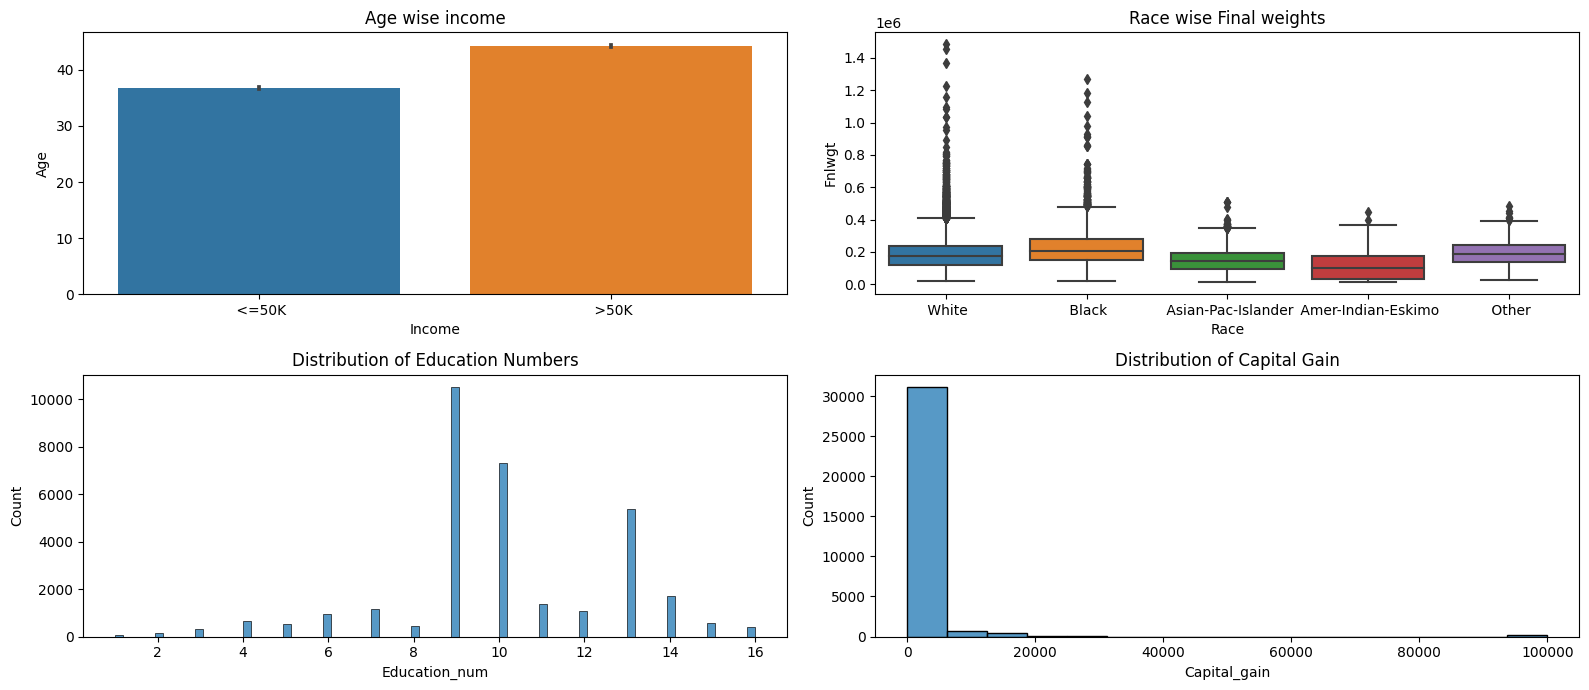

In [10]:
# 2x2 grid for subplots

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 7))

# Visualize how job satisfaction changes with change in Job level

sns.barplot(x='Income', y='Age', data=census_df, ax=axes[0, 0])
axes[0, 0].set_xlabel('Income')
axes[0, 0].set_ylabel('Age')
axes[0, 0].set_title('Age wise income')

sns.boxplot(x='Race', y='Fnlwgt', data=census_df, ax=axes[0, 1])
axes[0, 1].set_xlabel('Race')
axes[0, 1].set_ylabel('Fnlwgt')
axes[0, 1].set_title('Race wise Final weights')

sns.histplot(census_df['Education_num'], ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Education Numbers')

sns.histplot(census_df['Capital_gain'], ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Capital Gain')

plt.tight_layout()
plt.show()

In [11]:
# Number of outliers in each column

count_outliers = lambda column: (column < column.quantile(0.25) - 1.5 * (column.quantile(0.75) - column.quantile(0.25))) | (column > column.quantile(0.75) + 1.5 * (column.quantile(0.75) - column.quantile(0.25)))

columns = []

for i in census_df:
  if census_df[i].dtypes == "int64":
    columns.append(i)

for column in columns:
    num_outliers = count_outliers(census_df[column]).sum()
    print(f"Column '{column}' has {num_outliers} outliers.")

Column 'Age' has 143 outliers.
Column 'Fnlwgt' has 992 outliers.
Column 'Education_num' has 1198 outliers.
Column 'Capital_gain' has 2711 outliers.
Column 'Capital_loss' has 1519 outliers.
Column 'Hours_per_week' has 9008 outliers.


In [12]:
# Rectifying outlier using Winsorizing method

lower_bound = census_df.quantile(0.25)
upper_bound = census_df.quantile(0.75)

# Apply Winsorizing to each column

for column in columns:
    census_df[column] = np.where(census_df[column] < lower_bound[column], lower_bound[column], census_df[column])
    census_df[column] = np.where(census_df[column] > upper_bound[column], upper_bound[column], census_df[column])

In [13]:
# Again checking outliers

for column in columns:
    num_outliers = count_outliers(census_df[column]).sum()
    print(f"Column '{column}' has {num_outliers} outlier(s).")

Column 'Age' has 0 outlier(s).
Column 'Fnlwgt' has 0 outlier(s).
Column 'Education_num' has 0 outlier(s).
Column 'Capital_gain' has 0 outlier(s).
Column 'Capital_loss' has 0 outlier(s).
Column 'Hours_per_week' has 0 outlier(s).


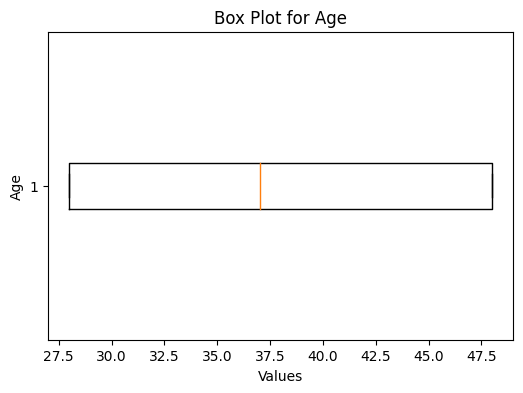

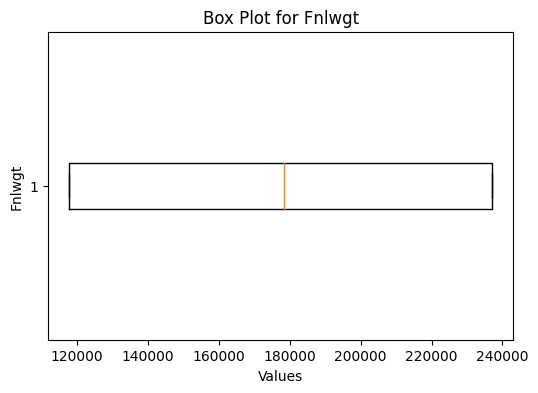

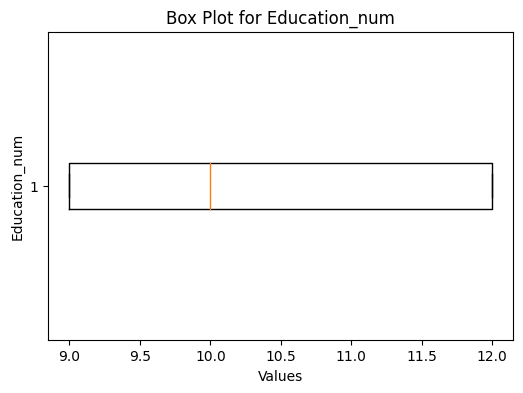

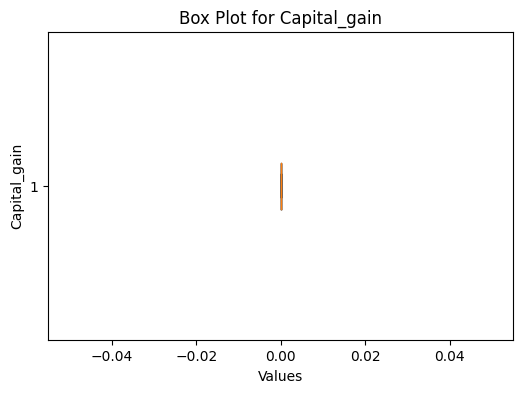

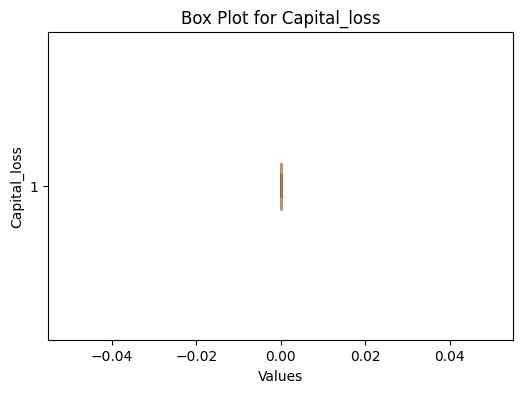

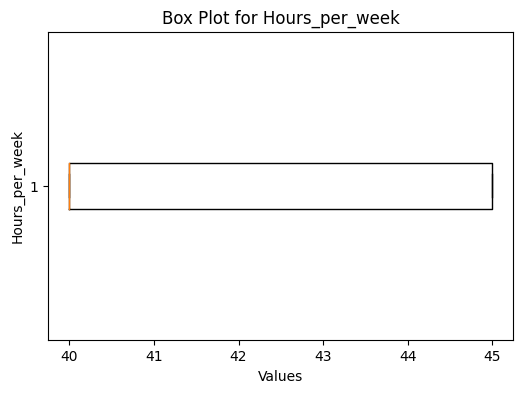

In [14]:
# Plot box plots for each column individually

for column in columns:
    plt.figure(figsize=(6, 4))
    plt.boxplot(census_df[column], vert=False)
    plt.title(f'Box Plot for {column}')
    plt.xlabel('Values')
    plt.ylabel(column)
    plt.show()

### At this point, we have removed all the outliers

In [15]:
# Building the correlation heatmap

corrs = census_df.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
figure.show()

### As we can see from the box plot and the correlation heatmap, "Capital Loss" and "Capital Gain" columns are narrowed down to 0 after outlier treatment, thus they are not effective for model building, thus dropping both of them

In [16]:
census_df.drop(['Capital_loss', 'Capital_gain'], axis=1, inplace=True)
census_df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Hours_per_week,Native_country,Income
0,48.0,Self-emp-not-inc,117831.5,Bachelors,12.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,40.0,United-States,<=50K
1,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,40.0,United-States,<=50K
2,48.0,Private,234721.0,11th,9.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40.0,United-States,<=50K
3,28.0,Private,237054.5,Bachelors,12.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40.0,Cuba,<=50K
4,37.0,Private,237054.5,Masters,12.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,40.0,United-States,<=50K


## Model Building

In [17]:
# Convert the target variable to binary (1 for '>50K' and 0 for '<=50K')

census_df['Income'] = census_df['Income'].apply(lambda x: 1 if x == '>50K' else 0)
census_df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Hours_per_week,Native_country,Income
0,48.0,Self-emp-not-inc,117831.5,Bachelors,12.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,40.0,United-States,0
1,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,40.0,United-States,0
2,48.0,Private,234721.0,11th,9.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40.0,United-States,0
3,28.0,Private,237054.5,Bachelors,12.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40.0,Cuba,0
4,37.0,Private,237054.5,Masters,12.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,40.0,United-States,0


In [18]:
# Drop columns that are not needed for modeling

census_df = census_df.drop(columns=['Fnlwgt', 'Education', 'Native_country'])

In [19]:
# Extracting the independent and dependent variables

X = census_df.drop(columns=['Income'])
y = census_df['Income']

In [20]:
# Encode the target variable

encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [21]:
# One-hot encode categorical features

X = pd.get_dummies(X, drop_first=True)

In [22]:
# Standardize the data

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=523)

In [25]:
# Deep neural network model with L2 regularization

model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    Dense(1, activation='sigmoid')
])

# Compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model

model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
326/326 [==============================] - 2s 3ms/step - loss: 0.4297 - accuracy: 0.9965 - val_loss: 0.0328 - val_accuracy: 1.0000
Epoch 2/10
326/326 [==============================] - 1s 2ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 3/10
326/326 [==============================] - 1s 2ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 4/10
326/326 [==============================] - 1s 2ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 5/10
326/326 [==============================] - 1s 2ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 8.4293e-04 - val_accuracy: 1.0000
Epoch 6/10
326/326 [==============================] - 1s 2ms/step - loss: 6.4181e-04 - accuracy: 1.0000 - val_loss: 4.7637e-04 - val_accuracy: 1.0000
Epoch 7/10
326/326 [==============================] - 1s 2ms/step - loss: 3.6681e-04 - accuracy: 1.0000 - val_loss: 2.7624e-04 - val_acc

In [26]:
# Evaluate the model on the test set

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

204/204 [==============================] - 0s 1ms/step - loss: 6.6890e-05 - accuracy: 1.0000
Test Loss: 6.689034489681944e-05, Test Accuracy: 1.0
